In [1]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset
import csv

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /content/daily-min-temperatures.csv

--2020-08-04 08:30:13--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/content/daily-min-temperatures.csv’

/content/daily-min- 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2020-08-04 08:30:14 (43.7 MB/s) - ‘/content/daily-min-temperatures.csv’ saved [67921/67921]



In [3]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [4]:
time_steps = []
temps = []

with open('daily-min-temperatures.csv') as filename:
  reader = csv.reader(filename, delimiter=',')
  next(reader)
  time = 0
  for row in reader:
    temps.append(float(row[1]))
    time_steps.append(int(time))
    time += 1

In [5]:
time = np.array(time_steps)
series = np.array(temps)

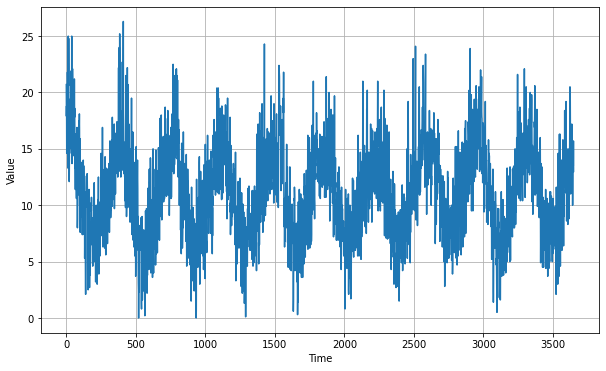

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [117]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  series = tf.expand_dims(series, axis=-1)
  ds = Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  ds = ds.batch(batch_size).prefetch(1)

  return ds

In [118]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [119]:
train = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [120]:
model = Sequential([
                    Conv1D(60,kernel_size = 5, activation='relu', strides=1, padding='causal', input_shape=[None,1]),
                    LSTM(60, return_sequences= True),
                    LSTM(60, return_sequences=True),
                    Dense(30, activation='relu'),
                    Dense(10, activation='relu'),
                    Dense(1),
                    Lambda(lambda x: x*400)
])

In [97]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9))
history = model.fit(train, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
10/10 [==============================] - 0s 22ms/step - loss: 58.5340
Epoch 2/100
10/10 [==============================] - 0s 29ms/step - loss: 56.9157
Epoch 3/100
10/10 [==============================] - 0s 32ms/step - loss: 54.4924
Epoch 4/100
10/10 [==============================] - 0s 33ms/step - loss: 51.6320
Epoch 5/100
10/10 [==============================] - 0s 33ms/step - loss: 48.4547
Epoch 6/100
10/10 [==============================] - 0s 35ms/step - loss: 44.9762
Epoch 7/100
10/10 [==============================] - 0s 31ms/step - loss: 41.1309
Epoch 8/100
10/10 [==============================] - 0s 34ms/step - loss: 36.8729
Epoch 9/100
10/10 [==============================] - 0s 29ms/step - loss: 32.2289
Epoch 10/100
10/10 [==============================] - 0s 31ms/step - loss: 27.1493
Epoch 11/100
10/10 [==============================] - 0s 36ms/step - loss: 21.8302
Epoch 12/100
10/10 [==============================] - 0s 31ms/step - loss: 16.7298
Epoch 13/100


(1e-08, 0.001, 0.0, 100.0)

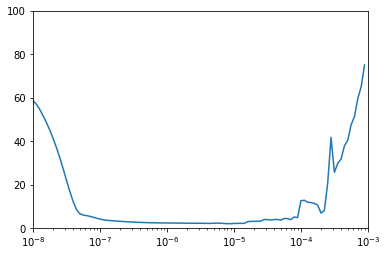

In [98]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-3, 0,100 ])

In [121]:
tf.keras.backend.clear_session()

train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer_size=shuffle_buffer_size)
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
history = model.fit(train, epochs=150)

Epoch 1/150
25/25 [==============================] - 0s 16ms/step - loss: 6.7217
Epoch 2/150
25/25 [==============================] - 0s 17ms/step - loss: 3.0259
Epoch 3/150
25/25 [==============================] - 0s 16ms/step - loss: 2.4119
Epoch 4/150
25/25 [==============================] - 0s 16ms/step - loss: 2.1730
Epoch 5/150
25/25 [==============================] - 0s 16ms/step - loss: 2.0650
Epoch 6/150
25/25 [==============================] - 0s 16ms/step - loss: 2.0059
Epoch 7/150
25/25 [==============================] - 0s 16ms/step - loss: 1.9699
Epoch 8/150
25/25 [==============================] - 0s 17ms/step - loss: 1.9523
Epoch 9/150
25/25 [==============================] - 0s 17ms/step - loss: 1.9368
Epoch 10/150
25/25 [==============================] - 0s 18ms/step - loss: 1.9249
Epoch 11/150
25/25 [==============================] - 0s 18ms/step - loss: 1.9161
Epoch 12/150
25/25 [==============================] - 0s 17ms/step - loss: 1.9101
Epoch 13/150
25/25 [=====

In [136]:
def model_forecast(model, series, window_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x: x.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)

  return forecast

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  series = tf.expand_dims(series, axis=-1)
  ds = Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  ds = ds.batch(batch_size).prefetch(1)

  return ds

In [137]:
preds = model_forecast(model, series, window_size)

In [138]:
preds.shape

(3621, 30, 1)

In [143]:
preds[:2]

array([[[11.347183 ],
        [12.993087 ],
        [13.795677 ],
        [15.324336 ],
        [14.537904 ],
        [14.911717 ],
        [15.757108 ],
        [15.851588 ],
        [16.581753 ],
        [16.505962 ],
        [16.023048 ],
        [15.489009 ],
        [16.319937 ],
        [17.633358 ],
        [18.516886 ],
        [17.36403  ],
        [17.297285 ],
        [18.286854 ],
        [17.16262  ],
        [16.944601 ],
        [17.80705  ],
        [13.594852 ],
        [15.469757 ],
        [16.085901 ],
        [15.986176 ],
        [17.536268 ],
        [17.870024 ],
        [17.07041  ],
        [16.50991  ],
        [16.169086 ]],

       [[11.2782345],
        [13.387428 ],
        [14.109201 ],
        [14.852673 ],
        [14.226036 ],
        [14.689825 ],
        [15.106773 ],
        [16.028517 ],
        [16.135962 ],
        [15.763662 ],
        [15.280822 ],
        [16.13017  ],
        [17.459942 ],
        [18.366953 ],
        [17.238878 ],
        

In [144]:
preds[0:2, -1,0]

array([16.169086, 16.0675  ], dtype=float32)

In [140]:
val_preds = preds[split_time-window_size:-1, -1,0]

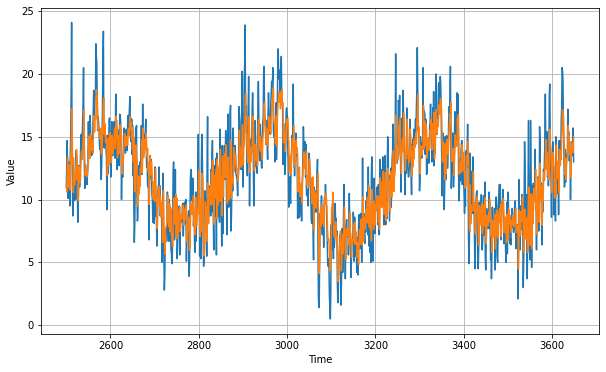

In [141]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, val_preds)

In [142]:
tf.keras.metrics.mean_absolute_error(x_valid, val_preds).numpy()

1.7797273